Import Libraries

In [1]:
from PyQt5.QtCore import *
import pandas as pd
from qgis.core import *
import os
import geopandas as gpd
import fiona
import sys
import math
import numpy
from shapely.geometry import shape
from shapely.geometry import Polygon
from rtree import index

In [2]:
# Increase width of notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Define functions to be used in script

In [3]:
# Create function to check for transect numbers of before and after points

def transectCheck(rownumber, dataframe):
    current = dataframe['Transect'].iloc[rownumber]
    after = dataframe['Transect'].iloc[rownumber + 1]
    if "/" in current:
        slash1 = current.find("/")
        slash2 = slash1 + 1
        current = current[slash2:]
    elif "," in current:
        slash1 = current.find(",")
        slash2 = slash1 + 1
        current = current[slash2:]
    else: pass
    
    if "/" in after:
        slash = after.find("/")
        after = after[:slash]
        
    elif "," in after:
        slash = after.find(",")
        after = after[:slash]
        
    else: pass
    
    if current == after:
        return 1
    else: return 0
    
    
# Create function to determine if a point is a mapping unit

def muCheck(rownumber, dataframe):

    # Check subclasses
    currentS = dataframe['Subclass'].iloc[rownumber][:2]
    beforeS = dataframe['Subclass'].iloc[rownumber - 1][:2]
    afterS = dataframe['Subclass'].iloc[rownumber + 1][:2]
    
    # Check 'Notes' field for mu
    
    
    if currentT == afterT and currentS == afterS: pass
    else:
            if currentT2 == beforeT and currentS == beforeS: pass
            else: return 2
            
def muClassCheck(rownumber, dataframe):

    currentS = dataframe['Class'].iloc[rownumber]
    beforeS = dataframe['Class'].iloc[rownumber - 1]
    afterS = dataframe['Class'].iloc[rownumber + 1]

    if currentT == afterT and currentS == afterS: pass
    else:
            if currentT2 == beforeT and currentS == beforeS: pass
            else: return 2
            
def muCheckLast(rownumber, dataframe):
    # Check final subclass with [-1] subclass only
    currentS = dataframe['Subclass'].iloc[rownumber][:2]
    beforeS = dataframe['Subclass'].iloc[rownumber - 1][:2]
    
    if currentS == beforeS: pass
    else: return 2
    
def muClassCheckLast(rownumber, dataframe):
    # Check final subclass with [-1] subclass only
    currentS = dataframe['Class'].iloc[rownumber][:2]
    beforeS = dataframe['Class'].iloc[rownumber - 1][:2]
    
    if currentS == beforeS: pass
    else: return 2

# Define function to test whether angle of mu corresponds to pre or post angle

def prepostCheck(rownumber, dataframe):
    currentT = dataframe['Transect'].iloc[rownumber]
    afterT = dataframe['Transect'].iloc[rownumber + 1]
    
    if "/" in currentT:
        slash1 = currentT.find("/")
        slash2 = slash1 + 1
        currentT = currentT[slash2:]
    else: pass
    
    if "/" in afterT:
        slash = afterT.find("/")
        afterT = afterT[:slash]
    else: pass
    
    if currentT == afterT: return "post"
    else: return "pre"
    
    

Set Up the Data - Specify correct folders to be generated

In [4]:
# Create directories within selected folder

# If tapping into Google Drive, folder may need to be availble offline

root = input("Enter file path to site folder in EPA Salt Marsh UAS Study with quotations -- ")
root = root[1:-1]
base = root + "\Jupyter_Working_Folder"
workIn = input("Enter in the date and site in the format: RR_14_Aug_2019 -- ")
currentWork = base + "\\" + workIn
XY_Points_Folder = currentWork + "\XY_Points"
Lines_Folder = currentWork + "\Lines"
Buffer_Folder = currentWork + "\Lines_Buffered"
Class_Lines_Folder = currentWork + "\Class_Lines"
Class_Buffer_Folder = currentWork + "\Class_Lines_Buffered"
mu_Folder = currentWork + "\mu"
mu_Buffer_Folder = currentWork + "\mu_Buffered"
working = currentWork + "\working"
Polygon_Folder = currentWork + "\Polygons"
folderList = [currentWork, XY_Points_Folder, Lines_Folder, Buffer_Folder, mu_Folder, 
              mu_Buffer_Folder, Class_Lines_Folder, Class_Buffer_Folder, working, Polygon_Folder]
for i in folderList:
    if not os.path.exists(i):
        os.makedirs(i)
        print(str(i) + " created.")
print("Folder creation complete.")

Enter file path to site folder in EPA Salt Marsh UAS Study with quotations -- "G:\.shortcut-targets-by-id\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\SaltMUAS_share\EPA Salt Marsh UAS Study\North River"
Enter in the date and site in the format: RR_14_Aug_2019 -- NR_21_Aug_2019
G:\.shortcut-targets-by-id\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\SaltMUAS_share\EPA Salt Marsh UAS Study\North River\Jupyter_Working_Folder\NR_21_Aug_2019 created.
G:\.shortcut-targets-by-id\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\SaltMUAS_share\EPA Salt Marsh UAS Study\North River\Jupyter_Working_Folder\NR_21_Aug_2019\XY_Points created.
G:\.shortcut-targets-by-id\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\SaltMUAS_share\EPA Salt Marsh UAS Study\North River\Jupyter_Working_Folder\NR_21_Aug_2019\Lines created.
G:\.shortcut-targets-by-id\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\SaltMUAS_share\EPA Salt Marsh UAS Study\North River\Jupyter_Working_Folder\NR_21_Aug_2019\Lines_Buffered created.
G:\.shortcut-targets-by-id\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\SaltMUAS_share\EPA Salt Marsh 

Check data to edit cell below to determine number of rows to exclude

In [5]:
# Read in .cvs with Transects
# Keep quotations around file path in the input
read_data = input("Enter file path to ground truthing data .csv here -- ")
read_data = read_data[1:-1]

# skiprows argument may need to be tweaked depending on format of the .csv's headers
df = pd.read_csv(read_data)

Enter file path to ground truthing data .csv here -- "G:\.shortcut-targets-by-id\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\SaltMUAS_share\EPA Salt Marsh UAS Study\North River\Ground Truthing\northriver21aug2019.csv"


In [6]:
# Observe number of rows to discard including RTC data
print("Preview of data:")
df.head()

Preview of data:


,Unnamed: 0,NAD 83 UTM 19N (EPSG Code: 26919),Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,NaN,Units: meters,NaN,NaN,NaN,NaN,NaN
1,TRANSECT,POINT #,SUBCLASS,NORTHING,EASTING,ELEVATION,NOTES
2,NaN,RTCM0052,NaN,4644294.626,362797.687,40.041,pathway
3,1,1,31,4670394.505,357429.934,1.173,flowering - open
4,1,2,06ac,4670396.306,357431.119,1.195,flowering - open


In [7]:
# Remove top rows of data if necessary
dat = input("If dataframe start at the correct positional row, enter 1, if not, enter 2 -- ")
if dat == "2":
    num = int(input("Enter in number of rows to discard -- "))
    if num == 1:
        datos = df.iloc[1:]
        dato = pd.DataFrame(datos)
        print("One row discarded")
    elif num == 2:
        datos = df.iloc[2:]
        dato = pd.DataFrame(datos)  
        print("Two rows discarded")
    elif num == 3:
        datos = df.iloc[3:]
        dato = pd.DataFrame(datos) 
        print("Three rows discarded")
    else:
        datos = df.iloc[4:]
        dato = pd.DataFrame(datos)  
        print("Rows discarded")
else: dato = pd.DataFrame(df)
dato.head()

If dataframe start at the correct positional row, enter 1, if not, enter 2 -- 2
Enter in number of rows to discard -- 3
Three rows discarded


,Unnamed: 0,NAD 83 UTM 19N (EPSG Code: 26919),Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
3,1,1,31,4670394.505,357429.934,1.173,flowering - open
4,1,2,06ac,4670396.306,357431.119,1.195,flowering - open
5,1,3,06a,4670398.116,357432.198,1.234,flowering - open
6,1,4,06a,4670401.102,357434.414,1.272,flowering - tight
7,1,5,06a,4670402.771,357435.806,1.258,flowering - tight


In [8]:
# Rename column headers
dato.columns = ['Transect', 'Point Number', 'Subclass', 'Northing', 'Easting', 'Altitude', 'Notes']

In [9]:
# Filter for null values where Transect != NaN 
filter_dato = dato[dato['Transect'].notnull()]

In [10]:
# Create empty fields for transect angles, Class, and mapping unit

filter_dato['Class'] = ""
filter_dato["Raw Subclass"] = ""
filter_dato['Pre Angle'] = ""
filter_dato['Post Angle'] = ""
filter_dato['mu'] = ""
filter_dato['Class mu'] = ""
filter_dato["Pre/Post"] = ""


# Preview the data
filter_dato.head()

,Transect,Point Number,Subclass,Northing,Easting,Altitude,Notes,Class,Raw Subclass,Pre Angle,Post Angle,mu,Class mu,Pre/Post
3,1,1,31,4670394.505,357429.934,1.173,flowering - open,,,,,,,
4,1,2,06ac,4670396.306,357431.119,1.195,flowering - open,,,,,,,
5,1,3,06a,4670398.116,357432.198,1.234,flowering - open,,,,,,,
6,1,4,06a,4670401.102,357434.414,1.272,flowering - tight,,,,,,,
7,1,5,06a,4670402.771,357435.806,1.258,flowering - tight,,,,,,,


In [11]:
# Use this cell to alter the data if needed

input("Press Enter after confirming cell alters data as needed; stop running Notebook if not")



Press Enter after confirming cell alters data as needed; stop running Notebook if not


In [13]:
# Convert any strings to floats or ints

filter_dato['Point Number'] = list(map(int, filter_dato['Point Number']))
filter_dato['Northing'] = list(map(float, filter_dato['Northing']))
filter_dato['Easting'] = list(map(float, filter_dato['Easting']))
filter_dato['Altitude'] = list(map(float, filter_dato['Altitude']))

In [14]:
# Define variables of lists of coordinates of current, before, and after coordinates
# This will be used to calculate angle from one point to the next

y = 0
precoordN = []
for x in filter_dato.iterrows():
    precoordN.append(filter_dato['Northing'].iloc[y-1])
    y += 1
y = 0
precoordE = []
for x in filter_dato.iterrows():
    precoordE.append(filter_dato['Easting'].iloc[y-1])
    y += 1
y = 0
currcoordN = []
for x in filter_dato.iterrows():
    currcoordN.append(filter_dato['Northing'].iloc[y])
    y += 1
y = 0
currcoordE = []
for x in filter_dato.iterrows():
    currcoordE.append(filter_dato['Easting'].iloc[y])
    y += 1
y = 0
postcoordN = []
for x in filter_dato.iterrows():
    if y+1 < len(filter_dato):
        postcoordN.append(filter_dato['Northing'].iloc[y+1])
        y += 1
    else: break
y = 0
postcoordE = []
for x in filter_dato.iterrows():
    if y+1 < len(filter_dato):
        postcoordE.append(filter_dato['Easting'].iloc[y+1])
        y += 1
    else: break

In [15]:
# # Convert any strings to floats

# precoordN = list(map(float, precoordN))
# precoordE = list(map(float, precoordE))
# currcoordN = list(map(float, currcoordN))
# currcoordE = list(map(float, currcoordE))
# postcoordN = list(map(float, postcoordN))
# postcoordE = list(map(float, postcoordE))

In [16]:
# Append calculated angles to lists
y = 0
preAngle = []
for i in filter_dato.iterrows():
    if y-1 < 0:
        preAngle.append(0)
        y += 1
    else:
        myradians = math.atan2(currcoordN[y]-precoordN[y], currcoordE[y]-precoordE[y])
        mydegrees = math.degrees(myradians)
        preAngle.append(mydegrees)
        y += 1

y = 0
postAngle = []
for i in filter_dato.iterrows():
    if y+1 < len(filter_dato):
        myradians = math.atan2(postcoordN[y]-currcoordN[y], postcoordE[y]-currcoordE[y])
        mydegrees = math.degrees(myradians)
        postAngle.append(mydegrees)
        y += 1
    else: 
        postAngle.append(0)
        y += 1       

In [17]:
# Parse out Class from Subclass and append to new list

classe = []
y = 0
for i in filter_dato.iterrows():
    if filter_dato['Subclass'].iloc[y][:1] == "0" or filter_dato['Subclass'].iloc[y][:1] == "1":
        classe.append(1)
        y += 1
    elif filter_dato['Subclass'].iloc[y][:1] == "2":
        classe.append(2)
        y += 1
    elif filter_dato['Subclass'].iloc[y][:1] == "3":
        classe.append(3)
        y += 1

In [18]:
# Parse out Raw Subclass data with only letters - no attribute letters

subraw = []
y = 0
for i in filter_dato["Subclass"]:
    subraw.append(str(i[:2]))

In [19]:
# Add lists to empty columns

filter_dato['Pre Angle'] = preAngle
filter_dato['Post Angle'] = postAngle
filter_dato['Class'] = classe
filter_dato["Raw Subclass"] = subraw

In [20]:
# Create new shapefile for Points that do not create a line
y = 0
muList = []

# for loop to write point for every mapping unit
for feat in filter_dato.iterrows():
    # Create if statement so you y is never > the length of your data set; this will end your script
    if y + 1 < len(filter_dato):
        if filter_dato['Raw Subclass'].iloc[y] == "13":
            muList.append(1)
        else:
            if muCheck(y, filter_dato) == 2:
                muList.append(1)



                y += 1
            else: 
                muList.append(0)
                y += 1
    else:
        muList.append(1)
        
# Repeart for Class mapping units

y = 0
ClassmuList = []
for feat in filter_dato.iterrows():
    if y + 1 < len(filter_dato):
        if muClassCheck(y, filter_dato) == 2:
            ClassmuList.append(1)
            
            

            y += 1
        else: 
            ClassmuList.append(0)
            y += 1
    else:
        ClassmuList.append(1)

In [21]:
# Append muList to dataframe
filter_dato['mu'] = muList
filter_dato['Class mu'] = ClassmuList

In [22]:
input("Keep value as zero if the last point in the data is not a mapping unit. Press Enter. ")
filter_dato['mu'][-1:] = 1

Keep value as zero if the last point in the data is not a mapping unit. Press Enter. 


C:\Users\brett\anaconda3\envs\CAFE\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
# Create for loop to create list of pre or post to append to dataframe
# This angle determines the angle the mapping unit should be rotated

y = 0
prepost = []

for i in filter_dato.iterrows():
    if y + 1 < len(filter_dato):
        pp = prepostCheck(y, filter_dato)
        prepost.append(pp)
        y += 1
    else: prepost.append("pre")

In [24]:
# Append prepost list to dataframe

filter_dato["Pre/Post"] = prepost

In [25]:
# Create QGIS XY Point Data into a List based on coordinates
point_list = [QgsPointXY(r['Easting'], r['Northing']) for i, r in filter_dato.iterrows() ]

In [26]:
# Create Multipoint list
points = QgsGeometry.fromMultiPointXY(point_list)

Create the XY Point Shapefile

In [27]:
# Create fields with correct data types

layerFields = QgsFields()
layerFields.append(QgsField('Transect', QVariant.String))
layerFields.append(QgsField('PointNum', QVariant.Int))
layerFields.append(QgsField('SubClass', QVariant.String))
layerFields.append(QgsField('Northing', QVariant.Double))
layerFields.append(QgsField('Easting', QVariant.Double))
layerFields.append(QgsField('Altitude', QVariant.Double))
layerFields.append(QgsField('Notes', QVariant.String))
layerFields.append(QgsField('Class', QVariant.Int))
layerFields.append(QgsField('Raw Subclass', QVariant.String))
layerFields.append(QgsField('Pre Angle', QVariant.Double))
layerFields.append(QgsField('Post Angle', QVariant.Double))
layerFields.append(QgsField('mu', QVariant.Int))
layerFields.append(QgsField('Class mu', QVariant.Int))
layerFields.append(QgsField('Pre/Post', QVariant.String))



True

In [28]:
# Set attributes by assigning to list assigned to variable
attributeList = [filter_dato['Transect'].iloc[y], \
                 int(filter_dato['Point Number'].iloc[y]), \
                 filter_dato['Subclass'].iloc[y], \
                 filter_dato['Northing'].iloc[y].item(), \
                 filter_dato['Easting'].iloc[y].item(), \
                 filter_dato['Altitude'].iloc[y].item(), \
                 filter_dato['Notes'].iloc[y], \
                 filter_dato['Class'].iloc[y].item(), \
                 filter_dato['Raw Subclass'].iloc[y], \
                 filter_dato['Pre Angle'].iloc[y].item(), \
                 filter_dato['Post Angle'].iloc[y].item(), \
                 filter_dato['mu'].iloc[y].item(),  \
                 filter_dato['Class mu'].iloc[y].item(), \
                 filter_dato['Pre/Post'].iloc[y]]

In [29]:
# Write XY Point Data for each row in .csv
# Specify output to variable
XY_Output_Path = XY_Points_Folder

In [30]:
# Use for loop to create shapefile
y = 0
for x in filter_dato.itertuples():
    # Specify file output and name of .shp
    file = XY_Output_Path + "\XYPoint" + str(y) + ".shp"
    # Set type (QgsWkbTypes.), CRS (EPSG:26919), and type of file (ESRI Shapefile)
    writer = QgsVectorFileWriter(file, 'UTF-8', layerFields, QgsWkbTypes.MultiPoint, QgsCoordinateReferenceSystem('EPSG:26919'), 'ESRI Shapefile')
    # Appends X and Y coordinates to variable 'point1' at the y position (starts at 0 and adds 1 for each iteration of the for loop)
    point1 = QgsGeometry.fromPointXY(point_list[y])
    # Create an empty feature
    feat = QgsFeature()
    # Set feature's geometry to that of point1
    feat.setGeometry(point1)
    # Set values from dataframe to attributes
    # Values will be applied in the order you created the layerFields
    feat.setAttributes([filter_dato['Transect'].iloc[y], \
                 int(filter_dato['Point Number'].iloc[y]), \
                 filter_dato['Subclass'].iloc[y], \
                 filter_dato['Northing'].iloc[y].item(), \
                 filter_dato['Easting'].iloc[y].item(), \
                 filter_dato['Altitude'].iloc[y].item(), \
                 filter_dato['Notes'].iloc[y], \
                 filter_dato['Class'].iloc[y].item(), \
                 filter_dato['Raw Subclass'].iloc[y], \
                 filter_dato['Pre Angle'].iloc[y].item(), \
                 filter_dato['Post Angle'].iloc[y].item(), \
                 filter_dato['mu'].iloc[y].item(),  \
                 filter_dato['Class mu'].iloc[y].item(), \
                 filter_dato['Pre/Post'].iloc[y]])
    # Add 1 to y to continue through the dataframe during next for loop
    y += 1
    # write the feature
    writer.addFeature(feat)

del(writer)

C:\Users\brett\anaconda3\envs\CAFE\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: QgsVectorFileWriter constructor is deprecated
  import sys


Concatenate all XY Point shapefiles into a single shapefile

In [31]:
# Specify which folder to look in
file = os.listdir(XY_Output_Path)

# Look for all files ending in ".shp"
path = [os.path.join(XY_Output_Path, i) for i in file if ".shp" in i]

# Concatenate to file specified in last line of code
gdf = gpd.GeoDataFrame(pd.concat([gpd.read_file(i) for i in path],
                        ignore_index=True), crs=gpd.read_file(path[0]).crs)
# Write to same folder + name of new folder to be created which will include the shapefile of compiled XY Points
XY_Points_Comp = "\XY_Points_Comp"

In [32]:
# Write concatenated files to output path
gdf.to_file(XY_Output_Path + XY_Points_Comp )

In [33]:
# Sort shapefile by Point Number attribute
# Assign XY_Points__Outfile to where the sorted compiled XY Points will be saved
XY_Points_outfile = XY_Output_Path + XY_Points_Comp + "\\XY_Points_Comp_Sort.shp"
# Designate which compiled shapefile will be sorted
filePath = XY_Output_Path + XY_Points_Comp + XY_Points_Comp + ".shp"
# Use geopandas to read in shapefile - Append read shapefile to variable 'shape'
shape = gpd.read_file(filePath)
# Sort based on Point Number
shape_sort = shape.iloc[shape['PointNum'].sort_values().index.values]

In [34]:
# Re-write file back out as sorted compiled shapefile
shape_sort.to_file(driver = 'ESRI Shapefile', filename = XY_Points_outfile)

Create PolyLine Shapefile

In [35]:
# Specify empty folder to put the Line files in
linesFolder = Lines_Folder
classlinesFolder = Class_Lines_Folder

In [59]:
# create variable to iterate through
shape = fiona.open(XY_Points_outfile)

In [60]:
# Create lines based on subclasses

# for loop to write line file between every 2 sequential points with matching sublass
y = 0
for feat in shape:
    # Create if statement so you y is never > the length of your data set; this will end your script
    if y + 1 < len(filter_dato):
        # What file to write
        file = linesFolder + "\line_" + str(y) + ".shp"
        # Same as previous writer, except QgsWkbTypes. is LineString
        writer = QgsVectorFileWriter(file, 'UTF-8', layerFields, QgsWkbTypes.LineString, \
                                 QgsCoordinateReferenceSystem('EPSG:26919'), 'ESRI Shapefile')
        # y point in point_list will act as the start of the line
        lineStart = point_list[y]
        # y + 1 point in point_list will act as the end of the line
        lineEnd = point_list[y+1]
        # Creates line based on the start and end points previously specified
        line = QgsGeometry.fromPolylineXY([lineStart, lineEnd])
        # Create empty feature for line
        linef = QgsFeature()
        # Set geometry to previously created PolyLine
        linef.setGeometry(line)
        # Append attributes from dataframe
        # Since the Line will consist of 2 points, both points' attributes must be stored in the line
        linef.setAttributes([filter_dato['Transect'].iloc[y], \
                 int(filter_dato['Point Number'].iloc[y]), \
                 filter_dato['Subclass'].iloc[y], \
                 filter_dato['Northing'].iloc[y].item(), \
                 filter_dato['Easting'].iloc[y].item(), \
                 filter_dato['Altitude'].iloc[y].item(), \
                 filter_dato['Notes'].iloc[y], \
                 filter_dato['Class'].iloc[y].item(), \
                 filter_dato['Raw Subclass'].iloc[y], \
                 filter_dato['Pre Angle'].iloc[y].item(), \
                 filter_dato['Post Angle'].iloc[y].item(), \
                 filter_dato['mu'].iloc[y].item(),  \
                 filter_dato['Class mu'].iloc[y].item(), \
                 filter_dato['Pre/Post'].iloc[y]])
        # if statement so a line is only written if it belongs to the same transect
        if filter_dato['Subclass'].iloc[y][:2] == filter_dato['Subclass'].iloc[y+1][:2] and transectCheck(y,filter_dato) == 1:
            if filter_dato['mu'].iloc[y] == 1:
                y +=1
            else:
                writer.addFeature(linef)
                y += 1
        else:
            y += 1
    else: break
del(writer)

C:\Users\brett\anaconda3\envs\CAFE\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: QgsVectorFileWriter constructor is deprecated
  if sys.path[0] == '':


In [38]:
# # Create lines based on Class

# # for loop to write line file between every 2 sequential points with matching Class
# y = 0
# for feat in shape:
#     # Create if statement so you y is never > the length of your data set; this will end your script
#     if y + 1 < len(filter_dato):
#         # What file to write
#         file = classlinesFolder + "\line_" + str(y) + ".shp"
#         # Same as previous writer, except QgsWkbTypes. is LineString
#         writer = QgsVectorFileWriter(file, 'UTF-8', layerFields, QgsWkbTypes.LineString, \
#                                  QgsCoordinateReferenceSystem('EPSG:26919'), 'ESRI Shapefile')
#         # y point in point_list will act as the start of the line
#         lineStart = point_list[y]
#         # y + 1 point in point_list will act as the end of the line
#         lineEnd = point_list[y+1]
#         # Creates line based on the start and end points previously specified
#         line = QgsGeometry.fromPolylineXY([lineStart, lineEnd])
#         # Create empty feature for line
#         linef = QgsFeature()
#         # Set geometry to previously created PolyLine
#         linef.setGeometry(line)
#         # Append attributes from dataframe
#         # Since the Line will consist of 2 points, both points' attributes must be stored in the line
#         linef.setAttributes([filter_dato['Transect'].iloc[y], \
#                  int(filter_dato['Point Number'].iloc[y]), \
#                  filter_dato['Subclass'].iloc[y], \
#                  filter_dato['Northing'].iloc[y].item(), \
#                  filter_dato['Easting'].iloc[y].item(), \
#                  filter_dato['Altitude'].iloc[y].item(), \
#                  filter_dato['Notes'].iloc[y], \
#                  filter_dato['Class'].iloc[y].item(), \
#                  filter_dato['Raw Subclass'].iloc[y], \
#                  filter_dato['Pre Angle'].iloc[y].item(), \
#                  filter_dato['Post Angle'].iloc[y].item(), \
#                  filter_dato['mu'].iloc[y].item(),  \
#                  filter_dato['Class mu'].iloc[y].item(), \
#                  filter_dato['Pre/Post'].iloc[y]])
#         # if statement so a line is only written if it belongs to the same transect
#         if filter_dato['Class'].iloc[y] == filter_dato['Class'].iloc[y+1] and transectCheck(y,filter_dato) == 1:
#             writer.addFeature(linef)
#             y += 1
#         else:
#             y += 1
#     else: break
# del(writer)

In [39]:
# Create mapping units based on subclasses

# Create new shapefile for Points that do not create a line

y = 0
shape = gpd.read_file(XY_Points_outfile)
muList2 = filter_dato['mu'].to_list()

# for loop to write point for every mapping unit
for i in muList2:
    # Create if statement so you y is never > the length of your data set; this will end your script
    if i == 1:
            
        # What file to write
        file = mu_Folder + "\mu_" + str(y) + ".shp"
        # Same as previous writer, except QgsWkbTypes. is Polygon
        writer = QgsVectorFileWriter(file, 'UTF-8', layerFields, QgsWkbTypes.MultiPoint, \
                                QgsCoordinateReferenceSystem('EPSG:26919'), 'ESRI Shapefile')
        poly1 = QgsGeometry.fromPointXY(point_list[y])
        feat1 = QgsFeature()
        feat1.setGeometry(poly1)
        feat1.setAttributes([filter_dato['Transect'].iloc[y], \
                 int(filter_dato['Point Number'].iloc[y]), \
                 filter_dato['Subclass'].iloc[y], \
                 filter_dato['Northing'].iloc[y].item(), \
                 filter_dato['Easting'].iloc[y].item(), \
                 filter_dato['Altitude'].iloc[y].item(), \
                 filter_dato['Notes'].iloc[y], \
                 filter_dato['Class'].iloc[y].item(), \
                 filter_dato['Raw Subclass'].iloc[y], \
                 filter_dato['Pre Angle'].iloc[y].item(), \
                 filter_dato['Post Angle'].iloc[y].item(), \
                 filter_dato['mu'].iloc[y].item(),  \
                 filter_dato['Class mu'].iloc[y].item(), \
                 filter_dato['Pre/Post'].iloc[y]])
        y += 1
        writer.addFeature(feat1)
    else: 
        y += 1
del(writer)

C:\Users\brett\anaconda3\envs\CAFE\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: QgsVectorFileWriter constructor is deprecated


In [61]:
# Create list of folders that contain newly created shapefiles to iterate through
concat_list = [linesFolder, mu_Folder]
n = 0

for i in concat_list:
    file = os.listdir(i)
    path = [os.path.join(i, x) for x in file if ".shp" in x]
    gdf = gpd.GeoDataFrame(pd.concat([gpd.read_file(x) for x in path],
                                    ignore_index=True), crs=gpd.read_file(path[0]).crs)
    if n == 0: gdf.to_file(i + "\\Lines_Comp")
    elif n == 1: gdf.to_file(i + "\\Class_Lines_Comp")
    else: gdf.to_file(i + "\\mu_Comp")
    
    n += 1

In [62]:
concat_fileList = [linesFolder + "\\Lines_Comp\\Lines_Comp.shp",
                   mu_Folder + "\\mu_Comp\\mu_Comp.shp"]

In [43]:
concat_fileList

['G:\\.shortcut-targets-by-id\\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\\SaltMUAS_share\\EPA Salt Marsh UAS Study\\North River\\Jupyter_Working_Folder\\NR_21_Aug_2019\\Lines\\Lines_Comp\\Lines_Comp.shp',
 'G:\\.shortcut-targets-by-id\\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\\SaltMUAS_share\\EPA Salt Marsh UAS Study\\North River\\Jupyter_Working_Folder\\NR_21_Aug_2019\\mu\\mu_Comp\\mu_Comp.shp']

Buffer time

In [63]:
# Buffer lines

# Assign empty folder to variable to write new file to
linesBufferFolder = Buffer_Folder
# Read in line shapefile of transects
lines= gpd.read_file(concat_fileList[0])
# Assign buffer and keep attributes
lines['geometry'] = lines.buffer(1, cap_style=3)
# Write new shapefile
lines.to_file(linesBufferFolder + "\\Lines_Buffer")

# # Buffer Class lines

# # Assign empty folder to variable to write new file to
# classlinesBufferFolder = Class_Buffer_Folder
# # Read in line shapefile of transects
# lines= gpd.read_file(concat_fileList[1])
# # Assign buffer and keep attributes
# lines['geometry'] = lines.buffer(1, cap_style=3)
# # Write new shapefile
# lines.to_file(classlinesBufferFolder + "\\Class_Lines_Buffer")

In [64]:
# Buffer the mapping units

# Specify which folder to look in to buffer mu
file = os.listdir(mu_Folder)

# Assign empty folder to variable to write new file to
muBufferFolder = mu_Buffer_Folder

# Begin buffer by iterating through each mapping unit
path = [os.path.join(mu_Folder, i) for i in file if ".shp" in i]
y = 0
for i in path:
    mus = gpd.read_file(path[y])
    if mus['Pre/Post'][0] == "post": 
        mus['geometry'] = mus.buffer(1, cap_style=3).rotate(mus["Post Angle"][0], origin='center')
        mus.to_file(muBufferFolder + "\\mu_" + str(mus["PointNum"][0]) + "_Buffer.shp")
    else: 
        mus['geometry'] = mus.buffer(1, cap_style=3).rotate(mus["Pre Angle"][0], origin='center')
        mus.to_file(muBufferFolder + "\\mu_" + str(mus["PointNum"][0]) + "_Buffer.shp")
    y += 1


In [65]:
# Concatenate mapping units

# Specify which folder to look in to compile mu
file = os.listdir(muBufferFolder)

# Look for all files ending in ".shp"
path = [os.path.join(muBufferFolder, i) for i in file if ".shp" in i]

# Concatenate to file specified in last line of code
gdf = gpd.GeoDataFrame(pd.concat([gpd.read_file(i) for i in path],
                        ignore_index=True), crs=gpd.read_file(path[0]).crs)
# Write to same folder + name of new folder to be created which will include the shapefile of compiled XY Points
# Variable below is the suffix to add to linesFolder to specify folder to store compiled line files
muCompSuff = "\\mu_Comp"
gdf.to_file(muBufferFolder + muCompSuff)

Erase the Duplicate Overlapping Dat

In [66]:
# Import libraries needed for erase

from itertools import combinations
from shapely.geometry import LineString
import matplotlib

In [67]:
# Read in transect polygons as GeoDataFrame

polygdf = gpd.GeoDataFrame.from_file(linesBufferFolder + "\\Lines_Buffer")

In [68]:
# Use itertools to iterate through all polys within shapefile by combination

for p1_idx, p2_idx in combinations(polygdf.geometry.index, 2):
    if polygdf.geometry.loc[p1_idx].intersects(polygdf.geometry.loc[p2_idx]):
        # Store intermediary results back to poly
        polygdf.geometry.loc[p2_idx] -= polygdf.geometry.loc[p1_idx]
# polygdf is now saved with the new geometry where it does not overlap itself

<AxesSubplot:>

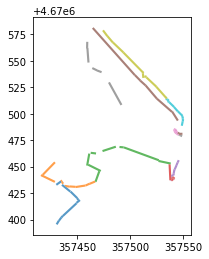

In [69]:
# Preview polygons using matplotlib
polygdf.plot(alpha=0.75, cmap="tab10")

In [70]:
mugdf = gpd.GeoDataFrame.from_file(muBufferFolder + muCompSuff)

In [71]:
for mu_idx in mugdf.geometry.index:
    for p1_idx in polygdf.geometry.index:
        if mugdf.geometry.loc[mu_idx].intersects(polygdf.geometry.loc[p1_idx]):
            # Store intermediary results back to poly
            polygdf.geometry.loc[p1_idx] -= mugdf.geometry.loc[mu_idx]

In [72]:
# Erase overlapping mapping untis

for p1_idx, p2_idx in combinations(mugdf.geometry.index, 2):
    if mugdf.geometry.loc[p1_idx].intersects(mugdf.geometry.loc[p2_idx]):
        # Store intermediary results back to poly
        mugdf.geometry.loc[p2_idx] -= mugdf.geometry.loc[p1_idx]
# mugdf is now saved with the new geometry where it does not overlap itself

Begin Final File Output

In [73]:
# Input Final Output Folder Path
rootOut = input("Enter Path of Site in UAS Data Collection (and Year if Applicable) to Write Final Output --- ")
rootOut = rootOut[1:-1]
workingFinal = rootOut + "\\Transects_Working"
transectFinal = rootOut + "\\Transects"

# Create list of variables with folder paths stored
finalfolderList = [workingFinal, transectFinal]

# Iterate through folder list and create folder if it does not already exist
for i in finalfolderList:
    if not os.path.exists(i):
        os.makedirs(i)
        print(str(i) + " created.")
print("Folder creation complete.")


Enter Path of Site in UAS Data Collection (and Year if Applicable) to Write Final Output --- "G:\.shortcut-targets-by-id\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\SaltMUAS_share\UAS Data Collection\North River\2019"
Folder creation complete.


In [74]:
# Specify date in the name of the shapefile

# Use previously defined workIn variable to name file
outShape = workingFinal + r"\\" + workIn + "_Transects_Final.shp"
outMu = workingFinal + r"\\" + workIn + "_mu_Final.shp"

polygdf.to_file(outShape)
mugdf.to_file(outMu)